**Review**

Hi, my name is Dmitry and I will be reviewing your project.
  
You can find my comments in colored markdown cells:
  
<div class="alert alert-success">
  If everything is done successfully.
</div>
  
<div class="alert alert-warning">
  If I have some (optional) suggestions, or questions to think about, or general comments.
</div>
  
<div class="alert alert-danger">
  If a section requires some corrections. Work can't be accepted with red comments.
</div>
  
Please don't remove my comments, as it will make further review iterations much harder for me.
  
Feel free to reply to my comments or ask questions using the following template:
  
<div class="alert alert-info">
  For your comments and questions.
</div>
  
First of all, thank you for turning in the project! You did a great job overall, but there are a couple of problems that need to be fixed before the project is accepted. Let me know if you have questions!

# Project description<br>
In this project we will analyze a database composed of 10,000 Beta Bank customers, with the purpose of training different Machine Learning models that can predict the permanence of customers in the bank. We will train three  algorithms (***Decision Tree***, ***Random Forest*** and ***Logistic Regression***) with a series of features that reflect the financial status and saving habits of customers, in order to have a variety of models able to predict the target variable ('Exited') with a reasonable degree of confidence.<br>

The first step will be to perform an Exploratory Data Analysis (EDA) focused on separating the ***'features'*** and ***'target'*** variables, defining the relevant features for the model, and preparing the data for machine learning using the techniques of ***One Hot Encoding (OHE)***, ***Label Encoding*** and ***Scalar Standardization***. We will then train three algorithms (Decision Tree, Random Forest and Logistic Regression) and note their initial performance, in a ***Class Imbalance*** state. In order to improve the performance of the models, we will use different techniques to mitigate class imbalance, such as the parameter ***class_weight='balanced'*** and ***upsampling/downsampling*** the training sets. After trying different combinations, we will select the optimal configuration for each algorithm and analyze the improvement in each model. Finally, we will measure the improvement in ***F1 scores*** for each model, test their reliability under different probability thresholds, and plot graphs of ***Recall-Precision curves*** and ***ROC curves with AUC-ROC*** scores to decide which model has the best performance.<br> 

## Import modules used in the project

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix 
from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score
from sklearn.utils import shuffle

## Load dataset, explore and clean data

In [2]:
df = pd.read_csv('/datasets/Churn.csv')
print(df.shape)
print(df.columns)
print(df.dtypes)
display(df.head())

(10000, 14)
Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')
RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure             float64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [3]:
# Find duplicated rows and null values
print("Duplicated rows:", df.duplicated().sum())
print("Null values:\n", df.isna().sum())

Duplicated rows: 0
Null values:
 RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64


<div class="alert alert-success">
<b>Reviewer's comment</b>

The data was loaded and inspected

</div>

In [4]:
# Explore the Null values
print(df['Tenure'].unique())
print(df['Tenure'].value_counts(dropna=False).sort_index())
display(df[df['Tenure'].isnull()].head())

[ 2.  1.  8.  7.  4.  6.  3. 10.  5.  9.  0. nan]
0.0     382
1.0     952
2.0     950
3.0     928
4.0     885
5.0     927
6.0     881
7.0     925
8.0     933
9.0     882
10.0    446
NaN     909
Name: Tenure, dtype: int64


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
30,31,15589475,Azikiwe,591,Spain,Female,39,NaN,0.00,3,1,0,140469.38,1
48,49,15766205,Yin,550,Germany,Male,38,NaN,103391.38,1,0,1,90878.13,0
51,52,15768193,Trevisani,585,Germany,Male,36,NaN,146050.97,2,0,0,86424.57,0
53,54,15702298,Parkhill,655,Germany,Male,41,NaN,125561.97,1,0,0,164040.94,1
60,61,15651280,Hunter,742,Germany,Male,35,NaN,136857.00,1,0,0,84509.57,0


The feature 'Tenure' - period of maturation for a customer’s fixed deposit (years) is the only feature that presents null values in the dataframe. They represent a significant percentage, close to 9% of all the rows, so we can't just drop them. We must find a way to deal with the null values later, if needed, because most machine learning algorhitms cannot handle missing values. 

<div class="alert alert-success">
<b>Reviewer's comment</b>

Alright!

</div>

## Prepare the data for Machine Learning modeling
First, we will separate the dataframe in 'target' and 'feature' variables. After this we can drop the features that are not essential to the model, since the inclusion of irrelevant features will likely confuse the algorithms and yield unreliable results. Then we can make the distinction between categorical and numerical features. The categorical values can be normalized using One Hot Encoding (OHE), and Label Encoding; and the numerical values can be standardized using Feature Scaling.

In [5]:
# Define 'target' and 'feature' variables
target = df['Exited']
features = df.drop('Exited', axis=1)
print("Target shape:", target.shape)
print("Target value counts:\n", target.value_counts())
print()
print("Features shape:", features.shape)
display(features.head())

Target shape: (10000,)
Target value counts:
 0    7963
1    2037
Name: Exited, dtype: int64

Features shape: (10000, 13)


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10


We can drop the following features:<br>
'RowNumber' - This feature only numerates the rows, so it doesn't offer any relevant information to the model. It is redundant because it has the same function as the index.<br>
'CustomerId', 'Surname' - These features are unique identifiers to each customer. They're nominal random features that do not have any correlation to the other features or the target. They're irrelevant to the model, so we can drop them.<br>

<div class="alert alert-success">
<b>Reviewer's comment</b>

Yep, that makes sense

</div>

In [6]:
# Drop the features that are not essential to the model
columns_to_drop = ['RowNumber', 'CustomerId', 'Surname']
features = features.drop(columns=columns_to_drop, axis=1)
display(features.head())

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10


We have to explore the values for each column in the 'features' variable, to decide if they're:<br>
• Nominal categorical values (suitable for One Hot Encoding)<br>
• Ordinal categorical values (suitable for Label Encoding)<br>
• Numerical continuous values (suitable for Standard Scaling)<br>

In [7]:
# Find the array of values for each feature.
# Write a function to print unique values for each column
def print_unique_values(data):
    categorical_columns = data.columns.tolist() # create a list of columns from the input parameter
    for column in categorical_columns:
        unique_values = np.sort(data[column].unique()) # sort the unique values for each collumn
        print(f"{column}:", unique_values) # print the column name and the array of unique values

print_unique_values(features)

CreditScore: [350 351 358 359 363 365 367 373 376 382 383 386 395 399 401 404 405 407
 408 410 411 412 413 414 415 416 417 418 419 420 421 422 423 424 425 426
 427 428 429 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444
 445 446 447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462
 463 464 465 466 467 468 469 470 471 472 473 474 475 476 477 478 479 480
 481 482 483 484 485 486 487 488 489 490 491 492 493 494 495 496 497 498
 499 500 501 502 503 504 505 506 507 508 509 510 511 512 513 514 515 516
 517 518 519 520 521 522 523 524 525 526 527 528 529 530 531 532 533 534
 535 536 537 538 539 540 541 542 543 544 545 546 547 548 549 550 551 552
 553 554 555 556 557 558 559 560 561 562 563 564 565 566 567 568 569 570
 571 572 573 574 575 576 577 578 579 580 581 582 583 584 585 586 587 588
 589 590 591 592 593 594 595 596 597 598 599 600 601 602 603 604 605 606
 607 608 609 610 611 612 613 614 615 616 617 618 619 620 621 622 623 624
 625 626 627 628 629 630 631 632 633 6

From the values displayed for each column we can assume the following distribution:<br>
• **Nominal categorical values:** 'Geography', 'Gender'<br>
• **Ordinal categorical values:** 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember'<br>
• **Numerical continuous values:** 'CreditScore', 'Age', 'Balance', 'EstimatedSalary'<br>

In [8]:
# Use One Hot Encoding on the 'features' variable. 
# (Drop_first=True) drops the first dummy feature to simplify the model
features = pd.get_dummies(features, drop_first=True)
display(features.head())

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,1,0


One Hot Encoding affected the following nominal categorical features:<br>
'Geography' - Has the values 'France', 'Germany' or 'Spain'. (OHE dropped Geography_France) <br>
'Gender' — Has the values Male or Female (OHE dropped Gender_Female).<br>
In both cases, no information is lost because a combination of 0's in the Germany and Spain columns = France, and a 0 in the Male column = Female.

In [9]:
# Use LabelEncoder on the 'features' variable. 
# Apply label encoding to the 'Tenure' column
label_encoder = LabelEncoder()
features['Tenure_encoded'] = label_encoder.fit_transform(features['Tenure'])
display(features.head())
print("Values in 'Tenure_encoded':", np.sort(features['Tenure_encoded'].unique()))

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male,Tenure_encoded
0,619,42,2.0,0.00,1,1,1,101348.88,0,0,0,2
1,608,41,1.0,83807.86,1,0,1,112542.58,0,1,0,1
2,502,42,8.0,159660.80,3,1,0,113931.57,0,0,0,8
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,1
4,850,43,2.0,125510.82,1,1,1,79084.10,0,1,0,2


Values in 'Tenure_encoded': [ 0  1  2  3  4  5  6  7  8  9 10 11]


In the case of Label Encoding, the only ordinal categorical feature that we believe is valid to encode is 'Tenure', since it presents a discrete sequence of integers that represent different conditions (N years left to maturation). This approach also solves the problem of the NaN values we found earlier, since the LabelEncoder treats them as a separate category, assigning them a distinct value (Nan = 11). It makes sense to categorize NaN values, because they can also be significant for machine learning, since their presence can represent a distinct state that might be relevant to the model.<br> 
The features 'NumOfProducts', 'HasCrCard' and 'IsActiveMember' seem to be reasonably clean and formatted for machine learning. For example, if we use LabelEncoder on the 'NumOfProducts' column, the output would be that the values [0,1,2,3] are replaced for [1,2,3,4]. There is no real benefit in doing this so it's better to leave these values as they are.

<div class="alert alert-warning">
<b>Reviewer's comment</b>

Yeah but replacing NaN with 11 is not canonical, e.g. it could have just as easily been encoded as 0 or -1, and the models will treat it as a numerical variable anyway

</div>

In [10]:
# Drop the 'Tenure' column and rename the 'Tenure_encoded' column
features = features.drop('Tenure', axis=1)
features.rename(columns={'Tenure_encoded': 'Tenure'}, inplace=True)
display(features.head())
print(features.shape)

,CreditScore,Age,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male,Tenure
0,619,42,0.00,1,1,1,101348.88,0,0,0,2
1,608,41,83807.86,1,0,1,112542.58,0,1,0,1
2,502,42,159660.80,3,1,0,113931.57,0,0,0,8
3,699,39,0.00,2,0,0,93826.63,0,0,0,1
4,850,43,125510.82,1,1,1,79084.10,0,1,0,2


(10000, 11)


<div class="alert alert-success">
<b>Reviewer's comment</b>

Good job encoding categorical features

</div>

In [11]:
# Split the 'target' and 'feature' variables in training, validation and test sets (60/20/20)
# Split 60/40 in Training and Temporary sets
features_train, features_temp, target_train, target_temp = train_test_split(
    features, target, test_size=0.4, random_state=12345)
# Split Temporary set 50/50 in Validation and Test sets
features_valid, features_test, target_valid, target_test = train_test_split(
    features_temp, target_temp, test_size=0.5, random_state=12345)

# Display shapes and first 5 rows
display(features_train.head())
display(features_train.shape)
display(target_train.head())
display(target_train.shape)
display(features_valid.head())
display(features_valid.shape)
display(target_valid.head())
display(target_valid.shape)
display(features_test.head())
display(features_test.shape)
display(target_test.head())
display(target_test.shape)

,CreditScore,Age,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male,Tenure
7479,567,35,153137.74,1,1,0,88659.07,0,1,1,8
3411,711,37,113899.92,1,0,0,80215.20,0,0,0,8
6027,850,44,140393.65,2,0,1,186285.52,1,0,1,3
1247,512,24,0.00,2,1,0,37654.31,0,0,1,6
3716,665,27,147435.96,1,0,0,187508.06,1,0,0,2


(6000, 11)

7479    0
3411    0
6027    0
1247    0
3716    0
Name: Exited, dtype: int64

(6000,)

,CreditScore,Age,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male,Tenure
8532,585,35,0.00,2,1,0,98621.04,0,0,0,2
5799,625,45,0.00,1,1,1,184474.15,0,0,0,3
5511,667,32,103846.65,1,1,0,20560.69,1,0,1,0
7365,568,36,153610.61,1,1,1,54083.80,0,1,0,10
7367,606,42,0.00,2,1,0,177938.52,0,1,1,10


(2000, 11)

8532    1
5799    1
5511    0
7365    1
7367    0
Name: Exited, dtype: int64

(2000,)

,CreditScore,Age,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male,Tenure
7041,438,38,0.00,2,1,0,136859.55,0,0,1,2
5709,644,39,0.00,1,1,0,3740.93,0,0,0,9
7117,564,31,121461.87,1,1,1,20432.09,0,1,1,5
7775,628,40,0.00,2,1,0,103832.58,0,1,1,10
8735,728,30,114835.43,1,0,1,37662.49,0,0,1,10


(2000, 11)

7041    0
5709    0
7117    1
7775    0
8735    0
Name: Exited, dtype: int64

(2000,)

In [12]:
# Use StandardScaler on the numeric columns in training, validation and test 'features' sets
# Define a list variable with numeric columnns
numeric = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']
# Apply StandardScaler to the numeric columns
scaler = StandardScaler()
# Training set
scaler.fit(features_train[numeric])
features_train[numeric].copy = scaler.transform(features_train[numeric])
# Validation set
scaler.fit(features_valid[numeric])
features_valid[numeric].copy = scaler.transform(features_valid[numeric])
# Test set
scaler.fit(features_test[numeric])
features_test[numeric].copy = scaler.transform(features_test[numeric])

display(features_train.head())
print(features_train.shape)
display(features_valid.head())
print(features_valid.shape)
display(features_test.head())
print(features_test.shape)

,CreditScore,Age,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male,Tenure
7479,567,35,153137.74,1,1,0,88659.07,0,1,1,8
3411,711,37,113899.92,1,0,0,80215.20,0,0,0,8
6027,850,44,140393.65,2,0,1,186285.52,1,0,1,3
1247,512,24,0.00,2,1,0,37654.31,0,0,1,6
3716,665,27,147435.96,1,0,0,187508.06,1,0,0,2


(6000, 11)


,CreditScore,Age,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male,Tenure
8532,585,35,0.00,2,1,0,98621.04,0,0,0,2
5799,625,45,0.00,1,1,1,184474.15,0,0,0,3
5511,667,32,103846.65,1,1,0,20560.69,1,0,1,0
7365,568,36,153610.61,1,1,1,54083.80,0,1,0,10
7367,606,42,0.00,2,1,0,177938.52,0,1,1,10


(2000, 11)


,CreditScore,Age,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male,Tenure
7041,438,38,0.00,2,1,0,136859.55,0,0,1,2
5709,644,39,0.00,1,1,0,3740.93,0,0,0,9
7117,564,31,121461.87,1,1,1,20432.09,0,1,1,5
7775,628,40,0.00,2,1,0,103832.58,0,1,1,10
8735,728,30,114835.43,1,0,1,37662.49,0,0,1,10


(2000, 11)


After transforming the numeric columns with StandardScaler, the data seems to be clean and formatted for machine learning.

<div class="alert alert-danger">
<b>Reviewer's comment</b>

Applying scaling before splitting the data can result in data leakage. To avoid it, apply scaling after splitting the data. The scaler is fit using the train set and all three (train, validation and test are transformed)

<div class="alert alert-info">
  Noted. I splitted the data first (Train, Validation and Test sets) and then applied the scaler.
</div>


## Train, test and improve different Machine Learning Models

<div class="alert alert-danger">
<b>Reviewer's comment</b>

Note that we need to split the data into three parts here: train, validation and test. A separate test set will be needed to get an unbiased estimate of our final model's generalization performance after we use the validation set to select it.

</div>

In [13]:
# Value_counts() of the Target variables
print(target_train.value_counts())
print(target_valid.value_counts())
print(target_test.value_counts())

0    4804
1    1196
Name: Exited, dtype: int64
0    1582
1     418
Name: Exited, dtype: int64
0    1577
1     423
Name: Exited, dtype: int64


Since this is a classification problem, we can quickly see the balance of the classes 1 and 0 by running the value_counts() function. The results show that the data is disbalanced towards Class 0.<br> 
We will train three models: **Decision Tree**, **Random Forest** and **Logistic Regression** and check their metrics (accuracy, recall, prediction and f1 score) under the class imbalance.

<div class="alert alert-success">
<b>Reviewer's comment</b>

Class imbalance was examined

</div>

In [14]:
# Evaluate the best hyperparameters for DecisionTreeClassifier 
# Define variables to store best_model and best_result
best_model = None
best_result = 0

# Loop over max_depth values from 1 to 10
for depth in range(1, 11):
    model = DecisionTreeClassifier(
        random_state=12345, max_depth=depth
    )
    model.fit(features_train, target_train)
    # Accuracy of model on training set
    predictions_train = model.predict(features_train)
    result_train = f1_score(target_train, predictions_train)
    # Accuracy of model on validation set
    predictions_valid = model.predict(features_valid)
    result = f1_score(target_valid, predictions_valid)
    print('max_depth =', depth, ': ', end='')
    print(result)
    # save the model with the best accuracy on the training set
    if result > best_result:
        best_model = model
        best_result = result
print()
print("F1 Score of the model on the training set:", result_train)
print("F1 Score of the best model on the validation set:", best_result)
print("Best model on the validation set:", best_model)

max_depth = 1 : 0.0
max_depth = 2 : 0.5217391304347825
max_depth = 3 : 0.4234875444839857
max_depth = 4 : 0.5528700906344411
max_depth = 5 : 0.5406249999999999
max_depth = 6 : 0.5666666666666667
max_depth = 7 : 0.5316846986089644
max_depth = 8 : 0.5303030303030303
max_depth = 9 : 0.5369318181818182
max_depth = 10 : 0.5492957746478873

F1 Score of the model on the training set: 0.7413622902270482
F1 Score of the best model on the validation set: 0.5666666666666667
Best model on the validation set: DecisionTreeClassifier(max_depth=6, random_state=12345)


<div class="alert alert-warning">
<b>Reviewer's comment</b>

It would be more appropriate to use the F1 score in the hyperparameter tuning loop for this and next models as F1 score is our target metric, not accuracy
    
<div class="alert alert-info">
Noted. I changed the code to display F1 scores instead of accuracy.    
</div>

Class Frequency - Decision Tree model
0    0.879
1    0.121
dtype: float64

Confusion Matrix:
 [[1527   55]
 [ 231  187]]

Accuracy Score: 0.857
Recall Score: 0.4473684210526316
Precision Score: 0.7727272727272727
F1 Score: 0.5666666666666667


<AxesSubplot:>

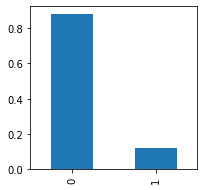

In [15]:
# 1)Decision Tree model (max_depth=6) and check its class balance.
tree = DecisionTreeClassifier(max_depth=6, random_state=12345)
tree.fit(features_train, target_train)
tree_valid = pd.Series(tree.predict(features_valid))
tree_frequency = tree_valid.value_counts(normalize=range(0,1))
print("Class Frequency - Decision Tree model")
print(tree_frequency)
print()
# Create a Confusion Matrix. Calculate Recall, Precision and F1 scores for the model
print("Confusion Matrix:\n", confusion_matrix(target_valid, tree_valid))
print()
print("Accuracy Score:", accuracy_score(target_valid, tree_valid))
print("Recall Score:", recall_score(target_valid, tree_valid))
print("Precision Score:", precision_score(target_valid, tree_valid))
print("F1 Score:", f1_score(target_valid, tree_valid))
tree_frequency.plot(kind='bar', figsize=(3,3))

In [16]:
# Evaluate the best hyperparameters for RandomForestClassifier
# Define variables to store best_model and best_result
best_model = None
best_result = 0

# Loop over max_depth values from 1 to 10
for depth in range(1, 11):
    model = RandomForestClassifier(
        random_state=12345, n_estimators=depth
    )
    model.fit(features_train, target_train)
    # Accuracy of model on training set
    predictions_train = model.predict(features_train)
    result_train = f1_score(target_train, predictions_train)
    # Accuracy of model on validation set
    predictions_valid = model.predict(features_valid)
    result = f1_score(target_valid, predictions_valid)
    print('n_estimators =', depth, ': ', end='')
    print(result)
    # save the model with the best accuracy on the training set
    if result > best_result:
        best_model = model
        best_result = result
print()
print("F1 score of the model on the training set:", result_train)
print("F1 score of the best model on the validation set:", best_result)
print("Best model on the validation set:", best_model)

n_estimators = 1 : 0.47344110854503463
n_estimators = 2 : 0.42996742671009774
n_estimators = 3 : 0.5382585751978892
n_estimators = 4 : 0.5169230769230769
n_estimators = 5 : 0.5524861878453039
n_estimators = 6 : 0.5423728813559322
n_estimators = 7 : 0.584958217270195
n_estimators = 8 : 0.5443609022556392
n_estimators = 9 : 0.559774964838256
n_estimators = 10 : 0.5508100147275404

F1 score of the model on the training set: 0.9628027681660899
F1 score of the best model on the validation set: 0.584958217270195
Best model on the validation set: RandomForestClassifier(n_estimators=7, random_state=12345)


Class Frequency - Random Forest model
0    0.85
1    0.15
dtype: float64

Confusion Matrix:
 [[1492   90]
 [ 208  210]]

Accuracy Score: 0.851
Recall Score: 0.5023923444976076
Precision Score: 0.7
F1 Score: 0.584958217270195


<AxesSubplot:>

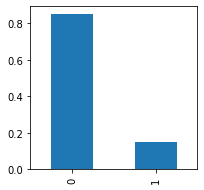

In [17]:
# 2)Random Forest model (n_estimators=7) and check its class balance.
forest = RandomForestClassifier(n_estimators=7, random_state=12345)
forest.fit(features_train, target_train)
forest_valid = pd.Series(forest.predict(features_valid))
forest_frequency = forest_valid.value_counts(normalize=range(0,1))
print("Class Frequency - Random Forest model")
print(forest_frequency)
print()
# Create a Confusion Matrix. Calculate Recall, Precision and F1 scores for the model
print("Confusion Matrix:\n", confusion_matrix(target_valid, forest_valid))
print()
print("Accuracy Score:", accuracy_score(target_valid, forest_valid))
print("Recall Score:", recall_score(target_valid, forest_valid))
print("Precision Score:", precision_score(target_valid, forest_valid))
print("F1 Score:", f1_score(target_valid, forest_valid))
forest_frequency.plot(kind='bar', figsize=(3,3))

Class Frequency - Logistic Regression model
0    0.9705
1    0.0295
dtype: float64

Confusion Matrix:
 [[1543   39]
 [ 398   20]]

Accuracy Score: 0.7815
Recall Score: 0.04784688995215311
Precision Score: 0.3389830508474576
F1 Score: 0.08385744234800838


<AxesSubplot:>

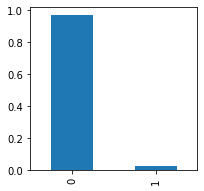

In [18]:
# 3) Logistic Regression model (solver='liblinear') and check its class balance.
logreg = LogisticRegression(solver='liblinear', random_state=12345)
logreg.fit(features_train, target_train)
logreg_valid = pd.Series(logreg.predict(features_valid))
logreg_frequency = logreg_valid.value_counts(normalize=range(0,1))
print("Class Frequency - Logistic Regression model")
print(logreg_frequency)
print()
# Create a Confusion Matrix. Calculate Recall, Precision and F1 scores for the model
print("Confusion Matrix:\n", confusion_matrix(target_valid, logreg_valid))
print()
print("Accuracy Score:", accuracy_score(target_valid, logreg_valid))
print("Recall Score:", recall_score(target_valid, logreg_valid))
print("Precision Score:", precision_score(target_valid, logreg_valid))
print("F1 Score:", f1_score(target_valid, logreg_valid))
logreg_frequency.plot(kind='bar', figsize=(3,3))

In all models we see a pronounced **Class Imbalance** that negatively affects their performance. The imbalance towards class 0 will make the models take a biased response in their predictions. This is reflected in the fact that, even thought **Accuracy** is relatively high in all models, they also present low **Recall**, **Precision** and **F1 scores**. After pre-processing the data for Machine Learning, we see that the poor performance of our models is mainly due to the Class Imbalance in the data. We must correct this imbalance to improve performance.

<div class="alert alert-success">
<b>Reviewer's comment</b>

Great, you trained a few mdoels without taking the imbalance into account first

</div>

## Correct Class Imbalance in the models

We will use several methods to correct Class Imbalance:<br>
**1) Using the class_weight='balanced' parameter in the models**

Class Frequency - Decision Tree model (balanced)
0    0.6815
1    0.3185
dtype: float64

Confusion Matrix:
 [[1238  344]
 [ 125  293]]

Accuracy Score: 0.7655
Recall Score: 0.7009569377990431
Precision Score: 0.4599686028257457
F1 Score: 0.5554502369668247


<AxesSubplot:>

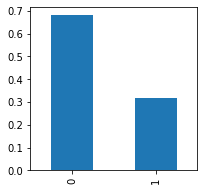

In [19]:
# 1)Decision Tree model (max_depth=6, class_weight='balanced') and check its class balance.
tree = DecisionTreeClassifier(max_depth=6, class_weight='balanced', random_state=12345)
tree.fit(features_train, target_train)
tree_valid = pd.Series(tree.predict(features_valid))
tree_frequency = tree_valid.value_counts(normalize=range(0,1))
print("Class Frequency - Decision Tree model (balanced)")
print(tree_frequency)
print()
# Create a Confusion Matrix. Calculate Recall, Precision and F1 scores for the model
print("Confusion Matrix:\n", confusion_matrix(target_valid, tree_valid))
print()
print("Accuracy Score:", accuracy_score(target_valid, tree_valid))
print("Recall Score:", recall_score(target_valid, tree_valid))
print("Precision Score:", precision_score(target_valid, tree_valid))
print("F1 Score:", f1_score(target_valid, tree_valid))
tree_frequency.plot(kind='bar', figsize=(3,3))

Class Frequency - Random Forest model (balanced)
0    0.856
1    0.144
dtype: float64

Confusion Matrix:
 [[1495   87]
 [ 217  201]]

Accuracy Score: 0.848
Recall Score: 0.48086124401913877
Precision Score: 0.6979166666666666
F1 Score: 0.5694050991501416


<AxesSubplot:>

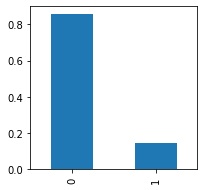

In [20]:
# 2)Random Forest model (n_estimators=7, class_weight='balanced') and check its class balance.
forest = RandomForestClassifier(n_estimators=7, class_weight='balanced', random_state=12345)
forest.fit(features_train, target_train)
forest_valid = pd.Series(forest.predict(features_valid))
forest_frequency = forest_valid.value_counts(normalize=range(0,1))
print("Class Frequency - Random Forest model (balanced)")
print(forest_frequency)
print()
# Create a Confusion Matrix. Calculate Recall, Precision and F1 scores for the model
print("Confusion Matrix:\n", confusion_matrix(target_valid, forest_valid))
print()
print("Accuracy Score:", accuracy_score(target_valid, forest_valid))
print("Recall Score:", recall_score(target_valid, forest_valid))
print("Precision Score:", precision_score(target_valid, forest_valid))
print("F1 Score:", f1_score(target_valid, forest_valid))
forest_frequency.plot(kind='bar', figsize=(3,3))

Class Frequency - Logistic Regression model (balanced)
0    0.6085
1    0.3915
dtype: float64

Confusion Matrix:
 [[1093  489]
 [ 124  294]]

Accuracy Score: 0.6935
Recall Score: 0.7033492822966507
Precision Score: 0.37547892720306514
F1 Score: 0.48959200666111574


<AxesSubplot:>

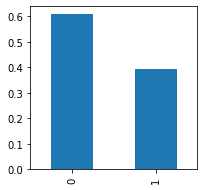

In [21]:
# 2) Logistic Regression model (solver='liblinear', class_weight='balanced') and check its class balance.
logreg = LogisticRegression(solver='liblinear', class_weight='balanced', random_state=12345)
logreg.fit(features_train, target_train)
logreg_valid = pd.Series(logreg.predict(features_valid))
logreg_frequency = logreg_valid.value_counts(normalize=range(0,1))
print("Class Frequency - Logistic Regression model (balanced)")
print(logreg_frequency)
print()
# Create a Confusion Matrix. Calculate Recall, Precision and F1 scores for the model
print("Confusion Matrix:\n", confusion_matrix(target_valid, logreg_valid))
print()
print("Accuracy Score:", accuracy_score(target_valid, logreg_valid))
print("Recall Score:", recall_score(target_valid, logreg_valid))
print("Precision Score:", precision_score(target_valid, logreg_valid))
print("F1 Score:", f1_score(target_valid, logreg_valid))
logreg_frequency.plot(kind='bar', figsize=(3,3))

Using the parameter **class_weight='balanced'** we slightly improved the F1 Score performance in the Logistic Regression model.<br>
On the other hand, the F1 Score performance slightly decreased on the Random Forest model, and it remained the same on the Decision Tree model. The Class Imbalance, however, improved for the Decision Tree.<br>

**Decision Tree**<br>
Accuracy Score: 0.86 to 0.77<br>
Recall Score: 0.44 to 0.70<br>
Precision Score: 0.77 to 0.46<br>
F1 Score: 0.56 to 0.56<br>

**Random Forest**<br>
Accuracy Score: 0.85 to 0.85<br>
Recall Score: 0.50 to 0.47<br>
Precision Score: 0.69 to 0.69<br>
F1 Score: 0.59 to 0.56<br>

**Logistic Regression**<br>
Accuracy Score: 0.80 to 0.70<br>
Recall Score: 0.22 to 0.67<br>
Precision Score: 0.57 to 0.38<br>
F1 Score: 0.32 to 0.48<br>

An improvement of the F1 Score reflects a better balance between Recall and Precision. This is the case for the Decision Tree and Logistic Regression models: Recall sharply improved in both models, while Precision diminished.<br>
The opposite is true for the Random Forest model: Recall diminished, while Precision remained the same.<br>
Based on these results, we conclude that the parameter *class_weight='balanced'* should be used on Decision Tree and Logistic Regression, but not on Random Forest.<br>
Even thought we see an improvement of the F1 scores, these are still too low to be accepted.

<div class="alert alert-success">
<b>Reviewer's comment</b>

Class weights were applied successfully
    
</div>

**2) Upsampling the training datasets**<br>
We will create a function to upsample and shuffle the training datasets, then train the models and evaluate their performance.

In [22]:
# Create a function to Upsample class 1 values in the trainings datasets
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345
    )

    return features_upsampled, target_upsampled


features_upsampled, target_upsampled = upsample(
    features_train, target_train, 4
)

<div class="alert alert-warning">
<b>Reviewer's comment</b>

Upsampling was correctly applied only to the train set, but does the chosen `repeat` parameter value make the data balanced?
<div class="alert alert-info">
Noted. I'm testing the class distribution of the upsampled set to make sure the repeat integer is adequate.    
</div>

In [23]:
# Check the class distribution after upsampling
class_dist = target_upsampled.value_counts()
print(class_dist)

0    4804
1    4784
Name: Exited, dtype: int64


<div class="alert alert-info">
    The class distribution is balanced using a repeat integer = 4
</div>

Class Frequency - Decision Tree model (upsampled)
0    0.6805
1    0.3195
dtype: float64

Confusion Matrix:
 [[1238  344]
 [ 123  295]]

Accuracy Score: 0.7665
Recall Score: 0.7057416267942583
Precision Score: 0.4616588419405321
F1 Score: 0.5581835383159887


<AxesSubplot:>

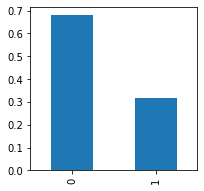

In [24]:
# 1)Decision Tree model (max_depth=6), train with upsampled dataset and check its class balance.
tree = DecisionTreeClassifier(max_depth=6, random_state=12345)
tree.fit(features_upsampled, target_upsampled)
tree_valid = pd.Series(tree.predict(features_valid))
tree_frequency = tree_valid.value_counts(normalize=range(0,1))
print("Class Frequency - Decision Tree model (upsampled)")
print(tree_frequency)
print()
# Create a Confusion Matrix. Calculate Recall, Precision and F1 scores for the model
print("Confusion Matrix:\n", confusion_matrix(target_valid, tree_valid))
print()
print("Accuracy Score:", accuracy_score(target_valid, tree_valid))
print("Recall Score:", recall_score(target_valid, tree_valid))
print("Precision Score:", precision_score(target_valid, tree_valid))
print("F1 Score:", f1_score(target_valid, tree_valid))
tree_frequency.plot(kind='bar', figsize=(3,3))

Class Frequency - Random Forest model (upsampled)
0    0.813
1    0.187
dtype: float64

Confusion Matrix:
 [[1433  149]
 [ 193  225]]

Accuracy Score: 0.829
Recall Score: 0.5382775119617225
Precision Score: 0.6016042780748663
F1 Score: 0.5681818181818181


<AxesSubplot:>

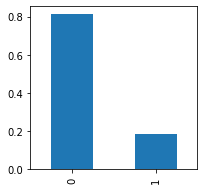

In [25]:
# 2)Random Forest model (n_estimators=7), train with upsampled dataset and check its class balance.
forest = RandomForestClassifier(n_estimators=7, random_state=12345)
forest.fit(features_upsampled, target_upsampled)
forest_valid = pd.Series(forest.predict(features_valid))
forest_frequency = forest_valid.value_counts(normalize=range(0,1))
print("Class Frequency - Random Forest model (upsampled)")
print(forest_frequency)
print()
# Create a Confusion Matrix. Calculate Recall, Precision and F1 scores for the model
print("Confusion Matrix:\n", confusion_matrix(target_valid, forest_valid))
print()
print("Accuracy Score:", accuracy_score(target_valid, forest_valid))
print("Recall Score:", recall_score(target_valid, forest_valid))
print("Precision Score:", precision_score(target_valid, forest_valid))
print("F1 Score:", f1_score(target_valid, forest_valid))
forest_frequency.plot(kind='bar', figsize=(3,3))

Class Frequency - Logistic Regression model (upsampled)
0    0.5845
1    0.4155
dtype: float64

Confusion Matrix:
 [[1040  542]
 [ 129  289]]

Accuracy Score: 0.6645
Recall Score: 0.6913875598086124
Precision Score: 0.34777376654632974
F1 Score: 0.4627702161729384


<AxesSubplot:>

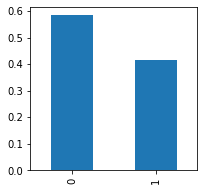

In [26]:
# 3) Logistic Regression model (solver='liblinear'), train with upsampled dataset and check its class balance.
logreg = LogisticRegression(solver='liblinear', random_state=12345)
logreg.fit(features_upsampled, target_upsampled)
logreg_valid = pd.Series(logreg.predict(features_valid))
logreg_frequency = logreg_valid.value_counts(normalize=range(0,1))
print("Class Frequency - Logistic Regression model (upsampled)")
print(logreg_frequency)
print()
# Create a Confusion Matrix. Calculate Recall, Precision and F1 scores for the model
print("Confusion Matrix:\n", confusion_matrix(target_valid, logreg_valid))
print()
print("Accuracy Score:", accuracy_score(target_valid, logreg_valid))
print("Recall Score:", recall_score(target_valid, logreg_valid))
print("Precision Score:", precision_score(target_valid, logreg_valid))
print("F1 Score:", f1_score(target_valid, logreg_valid))
logreg_frequency.plot(kind='bar', figsize=(3,3))

Using the **Upsampled** training sets slightly decreased the F1 Score performance in the Random Forest model, but it increased the performance of Logistic Regression. Decision Tree remained much the same, but the class imbalance improved.<br>

**Decision Tree**<br>
Accuracy Score: 0.86 to 0.77<br>
Recall Score: 0.44 to 0.70<br>
Precision Score: 0.77 to 0.46<br>
F1 Score: 0.56 to 0.56<br>

**Random Forest**<br>
Accuracy Score: 0.85 to 0.83<br>
Recall Score: 0.50 to 0.54<br>
Precision Score: 0.69 to 0.60<br>
F1 Score: 0.59 to 0.57<br>

**Logistic Regression**<br>
Accuracy Score: 0.80 to 0.70<br>
Recall Score: 0.22 to 0.67<br>
Precision Score: 0.57 to 0.38<br>
F1 Score: 0.32 to 0.49<br>

Based on these results, we conclude that the *Upsampled* training sets should be used in Logistic Regression, but not on Decision Tree and Random Forest.

<div class="alert alert-success">
<b>Reviewer's comment</b>

Upsampling was applied successfully

</div>

**3) Downsampling the training datasets**<br>
We will create a function to downsample and shuffle the training datasets, then train the models and evaluate their performance.

In [27]:
# Create a function to Downsample the values in the training datasets:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)]
        + [features_ones]
    )
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)]
        + [target_ones]
    )

    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345
    )

    return features_downsampled, target_downsampled


features_downsampled, target_downsampled = downsample(
    features_train, target_train, 0.25
)

In [28]:
# Check the class distribution after downsampling
class_dist = target_downsampled.value_counts()
print(class_dist)

0    1201
1    1196
Name: Exited, dtype: int64


<div class="alert alert-warning">
<b>Reviewer's comment</b>

Similarly to upsampling it seems the value of `fraction` parameter could be chosen to make the data more balanced
<div class="alert alert-info">
    Noted.  I'm testing the class distribution of the upsampled set to make sure the fraction factor is adequate.
</div>

Class Frequency - Decision Tree model (downsampled)
0    0.6805
1    0.3195
dtype: float64

Confusion Matrix:
 [[1246  336]
 [ 115  303]]

Accuracy Score: 0.7745
Recall Score: 0.7248803827751196
Precision Score: 0.47417840375586856
F1 Score: 0.5733207190160833


<AxesSubplot:>

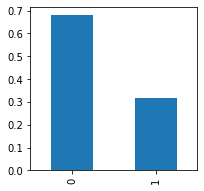

In [29]:
# 1)Decision Tree model (max_depth=6), train with downsampled dataset and check its class balance.
tree = DecisionTreeClassifier(max_depth=6, random_state=12345)
tree.fit(features_downsampled, target_downsampled)
tree_valid = pd.Series(tree.predict(features_valid))
tree_frequency = tree_valid.value_counts(normalize=range(0,1))
print("Class Frequency - Decision Tree model (downsampled)")
print(tree_frequency)
print()
# Create a Confusion Matrix. Calculate Recall, Precision and F1 scores for the model
print("Confusion Matrix:\n", confusion_matrix(target_valid, tree_valid))
print()
print("Accuracy Score:", accuracy_score(target_valid, tree_valid))
print("Recall Score:", recall_score(target_valid, tree_valid))
print("Precision Score:", precision_score(target_valid, tree_valid))
print("F1 Score:", f1_score(target_valid, tree_valid))
tree_frequency.plot(kind='bar', figsize=(3,3))

Class Frequency - Random Forest model (downsampled)
0    0.643
1    0.357
dtype: float64

Confusion Matrix:
 [[1184  398]
 [ 102  316]]

Accuracy Score: 0.75
Recall Score: 0.7559808612440191
Precision Score: 0.4425770308123249
F1 Score: 0.558303886925795


<AxesSubplot:>

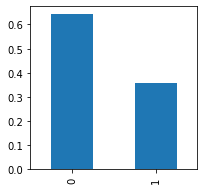

In [30]:
# 2)Random Forest model (n_estimators=7), train with downsampled dataset and check its class balance.
forest = RandomForestClassifier(n_estimators=7, random_state=12345)
forest.fit(features_downsampled, target_downsampled)
forest_valid = pd.Series(forest.predict(features_valid))
forest_frequency = forest_valid.value_counts(normalize=range(0,1))
print("Class Frequency - Random Forest model (downsampled)")
print(forest_frequency)
print()
# Create a Confusion Matrix. Calculate Recall, Precision and F1 scores for the model
print("Confusion Matrix:\n", confusion_matrix(target_valid, forest_valid))
print()
print("Accuracy Score:", accuracy_score(target_valid, forest_valid))
print("Recall Score:", recall_score(target_valid, forest_valid))
print("Precision Score:", precision_score(target_valid, forest_valid))
print("F1 Score:", f1_score(target_valid, forest_valid))
forest_frequency.plot(kind='bar', figsize=(3,3))

Class Frequency - Logistic Regression model (downsampled)
0    0.5775
1    0.4225
dtype: float64

Confusion Matrix:
 [[1022  560]
 [ 133  285]]

Accuracy Score: 0.6535
Recall Score: 0.6818181818181818
Precision Score: 0.33727810650887574
F1 Score: 0.4513064133016627


<AxesSubplot:>

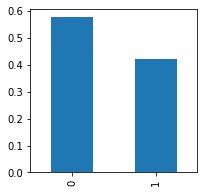

In [31]:
# 2) Logistic Regression model (solver='liblinear') and check its class balance.
logreg = LogisticRegression(solver='liblinear', random_state=12345)
logreg.fit(features_downsampled, target_downsampled)
logreg_valid = pd.Series(logreg.predict(features_valid))
logreg_frequency = logreg_valid.value_counts(normalize=range(0,1))
print("Class Frequency - Logistic Regression model (downsampled)")
print(logreg_frequency)
print()
# Create a Confusion Matrix. Calculate Recall, Precision and F1 scores for the model
print("Confusion Matrix:\n", confusion_matrix(target_valid, logreg_valid))
print()
print("Accuracy Score:", accuracy_score(target_valid, logreg_valid))
print("Recall Score:", recall_score(target_valid, logreg_valid))
print("Precision Score:", precision_score(target_valid, logreg_valid))
print("F1 Score:", f1_score(target_valid, logreg_valid))
logreg_frequency.plot(kind='bar', figsize=(3,3))

**Downsampling** the training datasets slightly decreased the F1 Score performance of the Random Forest model.<br>
In the case of Logistic Regression, altought *downsampling* increased the f1 score performance, this improvement was not as significant as the one we saw for *upsampling*.<br>
The Decision Tree f1 score also shows a slight improvement.<br>

**Decision Tree**<br>
Accuracy Score: 0.86 to 0.77<br>
Recall Score: 0.44 to 0.72<br>
Precision Score: 0.77 to 0.47<br>
F1 Score: 0.56 to 0.57<br>

**Random Forest**<br>
Accuracy Score: 0.85 to 0.75<br>
Recall Score: 0.50 to 0.76<br>
Precision Score: 0.69 to 0.44<br>
F1 Score: 0.59 to 0.56<br>

**Logistic Regression**<br>
Accuracy Score: 0.80 to 0.65<br>
Recall Score: 0.22 to 0.68<br>
Precision Score: 0.57 to 0.34<br>
F1 Score: 0.32 to 0.45<br>

Based on these results, we could conclude that the *Downsampled* training sets should be used on Decision Tree only, and not on Logistic Regression and Random Forest.<br> 
An interesting result, however, is that the Random Forest model presents a more balanced class frequency when trained with the downsampled datasets.<br>
***Class Frequency - Random Forest model (downsampled)<br> 
1 - 0.64<br> 
0 - 0.35***<br> 
For this reason, it's worth considering using the downsampled set for the Random Forest model to see how much it would optimize its performance.

<div class="alert alert-success">
<b>Reviewer's comment</b>

Great!

</div>

## Optimizing the models
After applying the **class_weight='balanced'** parameter and **Upsampling/Downsampling** the training sets, we can assume that, in order to optimize performance:<br> 

• the **Decision Tree** model will show the best performance by training it using the class_weight='balanced' parameter and the downsampled dataset.<br> 
• the **Random Forest** model will show the best performance by training it using the downsampled set.<br>
• the **Logistic Regression** model will show the best performance by training it using the class_weight='balanced' parameter and the upsampled dataset.<br>

However, the matter is not so simple, because models may still behave unpredictably, specially when applied to imbalanced sets. In our case, we must remember that the **test set** still maintains the original class imbalance.
We also need to consider both the **f1 score** and the **weighted average f1 score** (included in the Classification Report), since both metrics give us a different perspective on performance. Specially on an imbalanced dataset, the weighted average F1 score may give more importance to the performance on the minority class, while the F1 score provides a general measure of the model's ability to balance precision and recall. Although our models have been trained with datasets that have been balanced by the preceding *class balancing* techniques, the best approach will be to test different combinations for each model and select the one that performs best when applied to the test set.

For these reasons we will measure both metrics (**f1 score** and **weighted average f1 score**) of the three models applied to the **test set**, when trained under six different conditions:<br>
1) Original imbalanced training set<br>
2) Training set balanced with *class_weight='balanced'* parameter<br>
3) Training set balanced with *upsampling*<br>
4) Training set balanced with *downsampling*<br>
5) Training set balanced with *class_weight='balanced'* parameter and *upsampling*<br>
6) Training set balanced with *class_weight='balanced'* parameter and *downsampling*<br>

In [32]:
# Create function to evaluate all conditions for Decision Tree
def evaluate_decision_tree_model(classifier, features, target, label):
    classifier.fit(features, target)
    predictions = classifier.predict(features_test)
    
    print(f"Classification Report - Decision Tree model ({label}):")
    print(classification_report(target_test, predictions))
    
    f1 = f1_score(target_test, predictions)
    print(f"f1 Score - Decision Tree model ({label}): {f1}")
    
    print("="*80)

# 1) Decision Tree model (class imbalance)
tree = DecisionTreeClassifier(max_depth=6, random_state=12345)
evaluate_decision_tree_model(tree, features_train, target_train, "class imbalance")

# 2) Decision Tree model (class_weight='balanced')
tree_bal = DecisionTreeClassifier(max_depth=6, random_state=12345, class_weight='balanced')
evaluate_decision_tree_model(tree_bal, features_train, target_train, "class_weight='balanced'")

# 3) Decision Tree model (upsampled)
tree_up = DecisionTreeClassifier(max_depth=6, random_state=12345)
evaluate_decision_tree_model(tree_up, features_upsampled, target_upsampled, "upsampled")

# 4) Decision Tree model (downsampled)
tree_down = DecisionTreeClassifier(max_depth=6, random_state=12345)
evaluate_decision_tree_model(tree_down, features_downsampled, target_downsampled, "downsampled")

# 5) Decision Tree model (class_weight='balanced', upsampled)
tree_bal_up = DecisionTreeClassifier(max_depth=6, random_state=12345, class_weight='balanced')
evaluate_decision_tree_model(tree_bal_up, features_upsampled, target_upsampled, 
                             "class_weight='balanced', upsampled")

# 6) Decision Tree model (class_weight='balanced', downsampled)
tree_bal_down = DecisionTreeClassifier(max_depth=6, random_state=12345, class_weight='balanced')
evaluate_decision_tree_model(tree_bal_down, features_downsampled, target_downsampled, 
                             "class_weight='balanced', downsampled")


Classification Report - Decision Tree model (class imbalance):
              precision    recall  f1-score   support

           0       0.86      0.97      0.91      1577
           1       0.76      0.41      0.53       423

    accuracy                           0.85      2000
   macro avg       0.81      0.69      0.72      2000
weighted avg       0.84      0.85      0.83      2000

f1 Score - Decision Tree model (class imbalance): 0.5292307692307692
Classification Report - Decision Tree model (class_weight='balanced'):
              precision    recall  f1-score   support

           0       0.91      0.77      0.84      1577
           1       0.46      0.73      0.56       423

    accuracy                           0.76      2000
   macro avg       0.69      0.75      0.70      2000
weighted avg       0.82      0.76      0.78      2000

f1 Score - Decision Tree model (class_weight='balanced'): 0.5625570776255708
Classification Report - Decision Tree model (upsampled):
         

The results are as follows: <br>

*Decision Tree model (class imbalance)*<br>
weighted avg f1 score : 0.83<br>
f1 Score : 0.529<br>

*Decision Tree model (class_weight='balanced')*<br>
weighted avg f1 score : 0.78<br>
f1 Score : 0.562<br>

*Decision Tree model (upsampled)*<br>
weighted avg f1 score : 0.78<br>
f1 Score : 0.563<br>

*Decision Tree model (downsampled)*<br>
weighted avg f1 score : 0.79<br>
f1 Score : 0.588<br>

*Decision Tree model (class_weight='balanced', upsampled)*<br>
weighted avg f1 score : 0.78<br>
f1 Score : 0.562<br>

***Decision Tree model (class_weight='balanced', downsampled)***<br>
weighted avg f1 score : **0.79**<br>
f1 Score : **0.589**<br>

Based on these results, the optimized conditions for the training set are **Decision Tree model (class_weight='balanced', downsampled)**

In [33]:
# Create function to evaluate all conditions for Random Forest
def evaluate_random_forest_model(classifier, features, target, label):
    classifier.fit(features, target)
    predictions = classifier.predict(features_test)
    
    print(f"Classification Report - Random Forest model ({label}):")
    print(classification_report(target_test, predictions))
    
    f1 = f1_score(target_test, predictions)
    print(f"f1 Score - Random Forest model ({label}): {f1}")
    
    print("="*80)

# 1) Random Forest model (class imbalance)
forest = RandomForestClassifier(n_estimators=7, random_state=12345)
evaluate_random_forest_model(forest, features_train, target_train, "class imbalance")

# 2) Random Forest model (class_weight='balanced')
forest_bal = RandomForestClassifier(n_estimators=7, random_state=12345, class_weight='balanced')
evaluate_random_forest_model(forest_bal, features_train, target_train, "class_weight='balanced'")

# 3) Random Forest model (upsampled)
forest_up = RandomForestClassifier(n_estimators=7, random_state=12345)
evaluate_random_forest_model(forest_up, features_upsampled, target_upsampled, "upsampled")

# 4) Random Forest model (downsampled)
forest_down = RandomForestClassifier(n_estimators=7, random_state=12345)
evaluate_random_forest_model(forest_down, features_downsampled, target_downsampled, "downsampled")

# 5) Random Forest model (class_weight='balanced', upsampled)
forest_bal_up = RandomForestClassifier(n_estimators=7, random_state=12345, class_weight='balanced')
evaluate_random_forest_model(forest_bal_up, features_upsampled, target_upsampled, 
                             "class_weight='balanced', upsampled")

# 6) Random Forest model (class_weight='balanced', downsampled)
forest_bal_down = RandomForestClassifier(n_estimators=7, random_state=12345, class_weight='balanced')
evaluate_random_forest_model(forest_bal_down, features_downsampled, target_downsampled, 
                             "class_weight='balanced', downsampled")

Classification Report - Random Forest model (class imbalance):
              precision    recall  f1-score   support

           0       0.86      0.94      0.90      1577
           1       0.67      0.42      0.52       423

    accuracy                           0.83      2000
   macro avg       0.76      0.68      0.71      2000
weighted avg       0.82      0.83      0.82      2000

f1 Score - Random Forest model (class imbalance): 0.5173410404624277
Classification Report - Random Forest model (class_weight='balanced'):
              precision    recall  f1-score   support

           0       0.86      0.95      0.90      1577
           1       0.67      0.42      0.51       423

    accuracy                           0.83      2000
   macro avg       0.76      0.68      0.71      2000
weighted avg       0.82      0.83      0.82      2000

f1 Score - Random Forest model (class_weight='balanced'): 0.5138686131386861
Classification Report - Random Forest model (upsampled):
         

The results are as follows: <br>

*Random Forest model (class imbalance)*<br>
weighted avg f1 score : 0.82<br>
f1 Score : 0.517<br>

*Random Forest model (class_weight='balanced')*<br>
weighted avg f1 score : 0.82<br>
f1 Score : 0.513<br>

***Random Forest model (upsampled)***<br>
weighted avg f1 score : **0.82**<br>
f1 Score : **0.560**<br>

*Random Forest model (downsampled)*<br>
weighted avg f1 score : 0.76<br>
f1 Score : 0.532<br>

*Random Forest model (class_weight='balanced', upsampled)*<br>
weighted avg f1 score : 0.82<br>
f1 Score : 0.543<br>

*Random Forest model (class_weight='balanced', downsampled)*<br>
weighted avg f1 score : 0.77<br>
f1 Score : 0.558<br>

Based on these results, the optimized conditions for the training set are **Random Forest model (upsampled)**

In [34]:
# Create function to evaluate all conditions for Logistic Regression
def evaluate_logistic_regression_model(classifier, features, target, label):
    classifier.fit(features, target)
    predictions = classifier.predict(features_test)
    
    print(f"Classification Report - Logistic Regression model ({label}):")
    print(classification_report(target_test, predictions))
    
    f1 = f1_score(target_test, predictions)
    print(f"f1 Score - Logistic Regression model ({label}): {f1}")
    
    print("="*60)

# 1) Logistic Regression model (class imbalance)
logreg = LogisticRegression(solver='liblinear', random_state=12345)
evaluate_logistic_regression_model(logreg, features_train, target_train, "class imbalance")

# 2) Logistic Regression model (class_weight='balanced')
logreg_bal = LogisticRegression(solver='liblinear', class_weight='balanced', random_state=12345)
evaluate_logistic_regression_model(logreg_bal, features_train, target_train, "class_weight='balanced'")

# 3) Logistic Regression model (upsampled)
logreg_up = LogisticRegression(solver='liblinear', random_state=12345)
evaluate_logistic_regression_model(logreg_up, features_upsampled, target_upsampled, "upsampled")

# 4) Logistic Regression model (downsampled)
logreg_down = LogisticRegression(solver='liblinear', random_state=12345)
evaluate_logistic_regression_model(logreg_down, features_downsampled, target_downsampled, "downsampled")

# 5) Logistic Regression model (class_weight='balanced', upsampled)
logreg_bal_up = LogisticRegression(solver='liblinear', class_weight='balanced', random_state=12345)
evaluate_logistic_regression_model(logreg_bal_up, features_upsampled, target_upsampled, 
                                   "class_weight='balanced', upsampled")

# 6) Logistic Regression model (class_weight='balanced', downsampled)
logreg_bal_down = LogisticRegression(solver='liblinear', class_weight='balanced', random_state=12345)
evaluate_logistic_regression_model(logreg_bal_down, features_downsampled, target_downsampled, 
                                   "class_weight='balanced', downsampled")

Classification Report - Logistic Regression model (class imbalance):
              precision    recall  f1-score   support

           0       0.80      0.98      0.88      1577
           1       0.49      0.08      0.13       423

    accuracy                           0.79      2000
   macro avg       0.64      0.53      0.51      2000
weighted avg       0.73      0.79      0.72      2000

f1 Score - Logistic Regression model (class imbalance): 0.13441955193482688
Classification Report - Logistic Regression model (class_weight='balanced'):
              precision    recall  f1-score   support

           0       0.89      0.68      0.77      1577
           1       0.36      0.67      0.47       423

    accuracy                           0.68      2000
   macro avg       0.62      0.68      0.62      2000
weighted avg       0.77      0.68      0.71      2000

f1 Score - Logistic Regression model (class_weight='balanced'): 0.4698097601323408
Classification Report - Logistic Regressi

The results are as follows: <br>

*Logistic Regression model (class imbalance)*<br>
weighted avg f1 score : 0.72<br>
f1 Score : 0.134<br>

***Logistic Regression model (class_weight='balanced')***<br>
weighted avg f1 score : **0.71**<br>
f1 Score : **0.469**<br>

*Logistic Regression model (upsampled)*<br>
weighted avg f1 score : 0.67<br>
f1 Score : 0.425<br>

*Logistic Regression model (downsampled)*<br>
weighted avg f1 score : 0.67<br>
f1 Score : 0.427<br>

*Logistic Regression model (class_weight='balanced', upsampled)*<br>
weighted avg f1 score : 0.67<br>
f1 Score : 0.425<br>

*Logistic Regression model (class_weight='balanced', downsampled)*<br>
weighted avg f1 score : 0.67<br>
f1 Score : 0.428<br>

Based on these results, the optimized conditions for the training set are **Logistic Regression model (class_weight='balanced')**

The optimized models significantly improved both their **f1 score** and **weighted averaged f1 score**, compared to the *imbalanced* models. Since this is a binary classification problem, we will only need to consider the f1 score:<br>
1) Optimized Decision Tree model (class_weight='balanced', downsampled): **0.589**<br>
2) Optimized Random Forest model (upsampled): **0.560**<br>
3) Optimized Logistic Regression model (class_weight='balanced'): **0.469**<br>

***The only model that barely meets the minimum f1 score requirement (0.59) is the Optimized Decision Tree.***

<div class="alert alert-danger">
<b>Reviewer's comment</b>

When working with a binary classification problem we're looking at the F1 score for class 1 (the minority class), not the weighted average (this is used when we have more than 2 classes, for binary classification all relevant information is contained in the score for class 1)

<div class="alert alert-info">    
Thanks for this info. I am keeping the weighted avg f1 score in the code but only taking into account the f1 score.
</div>

## Test reliability of the models using Predicted probabilities, PR curve, ROC curve and AUC-ROC score.
In all classification models, we can improve the performance by predicting the different probabilities for Recall and Precision with different Thresholds. We will predict the probabilities of the optimized models for different thresholds, using the **predict_proba()** function. We will then select an optimal Threshold (one that meets a good balance between Precision and Recall) and run classification reports to see how much more the models can be improved. Finally, we will plot graphs of **Precision/Recall and ROC curves** and **AUC-ROC Scores** for the optimized models, to see their relative performance against a random model (0.50 accuracy).<br>

In [35]:
# create function to evaluate Precision, Recall and F1 scores for different thresholds
def evaluate_thresholds(model, features, target, threshold_range=np.arange(0.2, 0.8, 0.05)):
    probabilities = model.predict_proba(features)[:, 1]

    for threshold in threshold_range:
        predicted = probabilities > threshold 
        precision = precision_score(target, predicted)
        recall = recall_score(target, predicted)
        f1 = f1_score(target, predicted)

        print(
            'Threshold = {:.2f} | Precision = {:.3f}, Recall = {:.3f}, F1 Score = {:.3f}'.format(
                threshold, precision, recall, f1
            )
        )
        
# Evaluate thresholds for all optimized models
print("Optimized Decision Tree model (class_weight='balanced', downsampled)")
evaluate_thresholds(tree_bal_down, features_test, target_test)
print("="*80)
print("Optimized Random Forest model (upsampled)")
evaluate_thresholds(forest_up, features_test, target_test)
print("="*80)
print("Optimized Logistic Regression (class_weight='balanced')")
evaluate_thresholds(logreg_bal, features_test, target_test)

Optimized Decision Tree model (class_weight='balanced', downsampled)
Threshold = 0.20 | Precision = 0.310, Recall = 0.922, F1 Score = 0.464
Threshold = 0.25 | Precision = 0.375, Recall = 0.887, F1 Score = 0.527
Threshold = 0.30 | Precision = 0.383, Recall = 0.877, F1 Score = 0.533
Threshold = 0.35 | Precision = 0.383, Recall = 0.877, F1 Score = 0.533
Threshold = 0.40 | Precision = 0.442, Recall = 0.830, F1 Score = 0.576
Threshold = 0.45 | Precision = 0.448, Recall = 0.825, F1 Score = 0.581
Threshold = 0.50 | Precision = 0.481, Recall = 0.761, F1 Score = 0.590
Threshold = 0.55 | Precision = 0.481, Recall = 0.757, F1 Score = 0.588
Threshold = 0.60 | Precision = 0.512, Recall = 0.681, F1 Score = 0.585
Threshold = 0.65 | Precision = 0.613, Recall = 0.570, F1 Score = 0.591
Threshold = 0.70 | Precision = 0.611, Recall = 0.565, F1 Score = 0.587
Threshold = 0.75 | Precision = 0.706, Recall = 0.409, F1 Score = 0.518
Threshold = 0.80 | Precision = 0.706, Recall = 0.409, F1 Score = 0.518
Optimize

For all models, a standard **Threshold = 0.45 - 0.50** seems to meet the best balance between Precision/Recall and a higher F1 score.<br>

<div class="alert alert-success">
<b>Reviewer's comment</b>

It's nice that you tried different threshold values!

</div>

<div class="alert alert-danger">
<b>Reviewer's comment</b>

As noted above the correct metric to look at in this report is the F1 score for class 1
<div class="alert alert-info">
    Noted :)
</div>

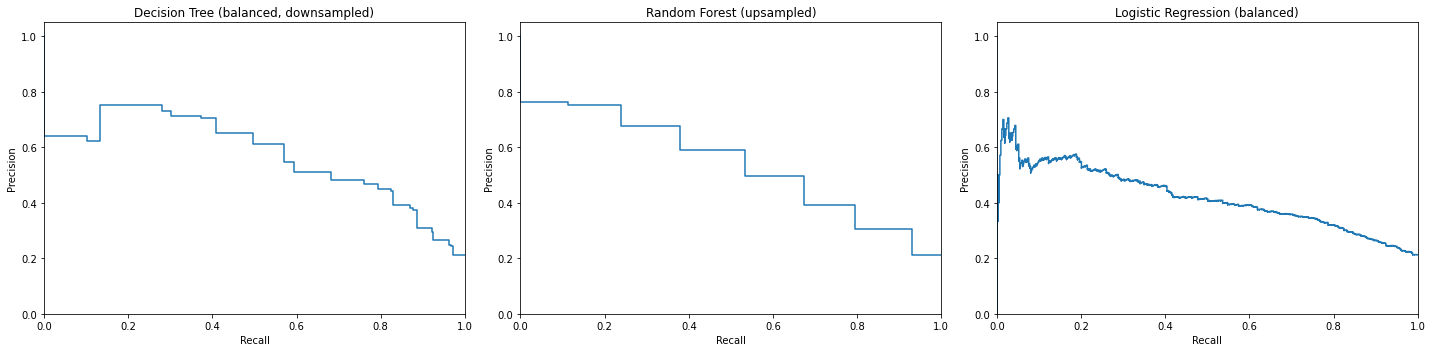

In [36]:
# PR Curves for all optimized models
models = [tree_bal_down, forest_up, logreg_bal]
model_names = ['Decision Tree (balanced, downsampled)', 'Random Forest (upsampled)', 
               'Logistic Regression (balanced)']

def plot_precision_recall_curves(models, model_names, features_test, target_test, figsize=(20, 5)):
    plt.figure(figsize=figsize)

    for i, (model, model_name) in enumerate(zip(models, model_names), start=1):
        probabilities = model.predict_proba(features_test)[:, 1]
        precision, recall, _ = precision_recall_curve(target_test, probabilities)

        plt.subplot(1, len(models), i)
        plt.step(recall, precision, where='post')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
        plt.title(model_name)

    plt.tight_layout()
    plt.show()


# Plot PR curves for all optimized models
plot_precision_recall_curves(models, model_names, features_test, target_test)

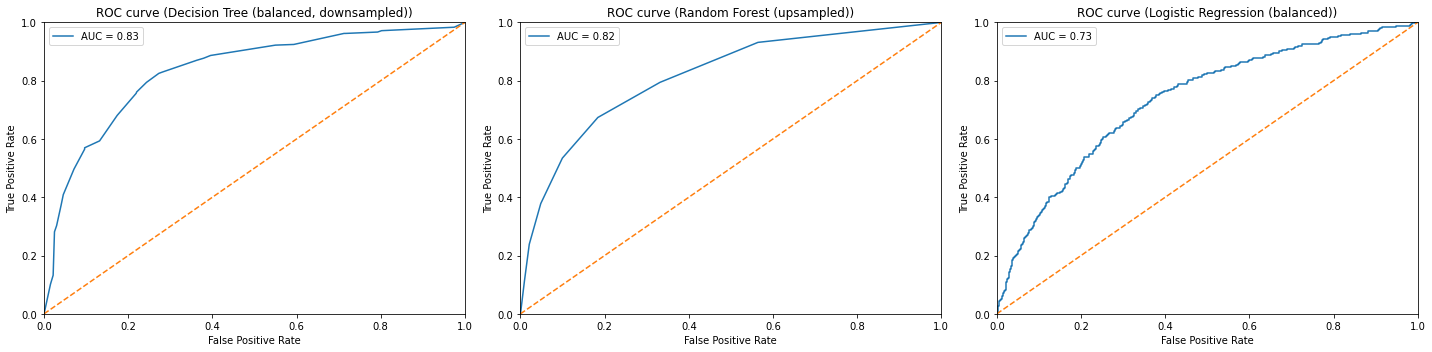

In [37]:
# Plot ROC Curves and AUC-ROC scores for all optimized models
# Create function to plot ROC curves and AUC-ROC scores
def plot_roc_curves(models, model_names, features_test, target_test, figsize=(20, 5)):
    plt.figure(figsize=figsize)

    for i, (model, model_name) in enumerate(zip(models, model_names), start=1):
        probabilities = model.predict_proba(features_test)[:, 1]
        fpr, tpr, _ = roc_curve(target_test, probabilities)
        auc = roc_auc_score(target_test, probabilities)

        plt.subplot(1, len(models), i)
        plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
        plt.plot([0, 1], [0, 1], linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC curve ({model_name})')
        plt.legend()

    plt.tight_layout()
    plt.show()

plot_roc_curves(models, model_names, features_test, target_test)

<div class="alert alert-success">
<b>Reviewer's comment</b>

It's great that you plotted the ROC curves for the models!

</div>

<div class="alert alert-danger">
<b>Reviewer's comment</b>

After selecting the best model and the best balancing technique using the validation set, please evaluate it using the test set for an unbiased estimate of its generalization performance
<div class="alert alert-info">
    Noted.
</div>

## Conclusion
The f1 scores and AUC-ROC scores of our optimized models are:<br>

***1) Optimized Decision Tree model (class_weight='balanced', downsampled)***<br>
f1 score: 0.589<br>
AUC-ROC score: 0.83<br>

***2) Optimized Random Forest model (upsampled)***<br>
f1 score: 0.560<br>
AUC-ROC score: 0.82<br>

***3) Optimized Logistic Regression model (class_weight='balanced')***<br>
f1 score: 0.469<br>
AUC-ROC score: 0.73<br>

We can argue that all of them could be acceptable models for predicting whether Beta Bank's customers are likely to stay.<br>
The best model is Decision Tree with an **AUC-ROC score = 0.83** and a **f1 score = 0.589**<br>

This project has shown that optimization analysis is very effective in improving the performance of a model. After cleaning and preparing the data for machine learning, and training different models, we initially found that each model performed very poorly (f1 score < 0.59). Correcting the class imbalance and analyzing how each method affected the models allowed us to make decisions that, when combined, were able to improve performance in each specific case. Finally, testing the metrics of the optimized models (f1 score, PR curve, ROC curve, AUC-ROC score) showed that these methods were highly effective in improving the performance of the models as a whole.

<div class="alert alert-danger">
<b>Reviewer's comment</b>

Please use the F1 scores for class 1 for the conclusion

</div>